- http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/

- 名前のも時系列からその人の所属国を推測する
- category = language
- line = name

In [7]:
!wget https://download.pytorch.org/tutorial/data.zip

--2018-03-23 10:27:17--  https://download.pytorch.org/tutorial/data.zip
download.pytorch.org (download.pytorch.org) をDNSに問いあわせています... 52.222.201.66, 52.222.201.169, 52.222.201.225, ...
download.pytorch.org (download.pytorch.org)|52.222.201.66|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 2882130 (2.7M) [application/zip]
`data.zip' に保存中

data.zip            100%[===================>]   2.75M  10.1MB/s 時間 0.3s       

2018-03-23 10:27:19 (10.1 MB/s) - `data.zip' へ保存完了 [2882130/2882130]



In [135]:
from io import open
import glob

import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

In [11]:
def findFiles(path):
    return glob.glob(path)

In [12]:
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [33]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [34]:
n_letters

57

In [21]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [26]:
# language => [names ...]
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [27]:
all_categories

['Czech',
 'German',
 'Arabic',
 'Japanese',
 'Chinese',
 'Vietnamese',
 'Russian',
 'French',
 'Irish',
 'English',
 'Spanish',
 'Greek',
 'Italian',
 'Portuguese',
 'Scottish',
 'Dutch',
 'Korean',
 'Polish']

In [28]:
category_lines.keys()

dict_keys(['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish'])

In [30]:
category_lines['Japanese'][:5]

['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']

In [107]:
def letterToIndex(letter):
    return all_letters.find(letter)

# 文字を1-of-Kに変換する
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# lineは1人分の名前の文字列リスト
def lineToTensor(line):
    # seq = 名前の文字の系列
    # バッチは1とする
    # seq_len, batch, input_size
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [49]:
letterToTensor('J').size()

torch.Size([1, 57])

In [50]:
lineToTensor('Jones').size()

torch.Size([5, 1, 57])

## Creating the Network

- LSTMを使ってない純粋なRNNを実装

In [119]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [120]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128)
  (i2o): Linear(in_features=185, out_features=18)
  (softmax): LogSoftmax()
)

In [121]:
print(n_letters)
print(n_hidden)
print(n_categories)

57
128
18


In [122]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))
output, next_hidden = rnn(input, hidden)

In [123]:
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [124]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))
output, next_hidden = rnn(input[0], hidden)
print(output.size())
print(output)

torch.Size([1, 18])
Variable containing:

Columns 0 to 9 
-2.9306 -2.8015 -2.9023 -2.8764 -3.0084 -2.9089 -2.8674 -2.8317 -2.8988 -2.8322

Columns 10 to 17 
-2.9619 -2.8694 -2.9615 -2.9347 -2.8597 -2.8363 -2.9008 -2.8681
[torch.FloatTensor of size 1x18]



## Preparing for Training

In [125]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

In [126]:
print(categoryFromOutput(output))

('German', 1)


In [127]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

- 名前によって系列長が異なるので注意！

In [128]:
category, line, category_tensor, line_tensor = randomTrainingExample()
print(category)  # Language
print(line)  # name
print(category_tensor)  # target label
print(line_tensor.size())  # 名前の文字系列データ

Vietnamese
Cao
Variable containing:
 5
[torch.LongTensor of size 1]

torch.Size([3, 1, 57])


In [129]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Cattaneo
category = Vietnamese / line = Tron
category = Vietnamese / line = To
category = Korean / line = Chun
category = Japanese / line = Koiso
category = Polish / line = Lis
category = Japanese / line = Hishikawa
category = English / line = Kennard
category = Spanish / line = Guerrero
category = Italian / line = Nicotera


## Training the Network

In [130]:
learning_rate = 0.005
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [131]:
# 1人分の名前（文字系列）と言語を与えた場合の訓練関数
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    # 系列を処理
    # 文字系列を読み込ませている間はhiddenを次にまわす
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    # 系列をすべて処理し終わったあとのoutputを正解と比較する
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [132]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.1626 Docherty / Russian ✗ (Scottish)
10000 10% (0m 15s) 2.0009 Wilson / Russian ✗ (Scottish)
15000 15% (0m 23s) 2.8521 Donndubhan / Russian ✗ (Irish)
20000 20% (0m 31s) 1.1214 Jedlicka / Czech ✓
25000 25% (0m 38s) 3.2612 Niftrik / Czech ✗ (Dutch)
30000 30% (0m 46s) 2.3395 Butt / German ✗ (English)
35000 35% (0m 53s) 3.0943 Gerges / Portuguese ✗ (Arabic)
40000 40% (1m 1s) 1.0443 Bei / Vietnamese ✗ (Chinese)
45000 45% (1m 8s) 1.7112 Espina / Spanish ✓
50000 50% (1m 16s) 1.2234 Olivier / French ✓
55000 55% (1m 23s) 1.6722 Merlo / Portuguese ✗ (Italian)
60000 60% (1m 32s) 1.5825 Zawisza / Polish ✓
65000 65% (1m 39s) 0.2946 Varela / Spanish ✓
70000 70% (1m 48s) 2.9263 Seeger / German ✗ (Dutch)
75000 75% (1m 58s) 2.2989 Kalb / Scottish ✗ (Arabic)
80000 80% (2m 8s) 1.4907 Vargas / Greek ✗ (Portuguese)
85000 85% (2m 16s) 2.3687 Gordon / Irish ✗ (Scottish)
90000 90% (2m 23s) 2.1679 San nicolas / Portuguese ✗ (Spanish)
95000 95% (2m 31s) 0.3186 Grygarova / Czech ✓
100000 100% (

## Plotting the Results

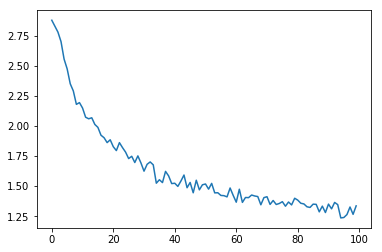

In [136]:
plt.figure()
plt.plot(all_losses)

## Evaluating the Results

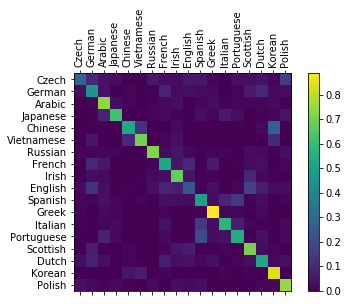

In [141]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# ラベルを強制的に表示する
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

## Running on User Input

In [142]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))
    
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [143]:
predict('Dovesky')


> Dovesky
(-0.24) Russian
(-1.81) Czech
(-4.02) English


In [144]:
predict('Mori')


> Mori
(-0.98) Italian
(-1.49) Japanese
(-2.68) Arabic


In [149]:
predict('Koichiro')


> Koichiro
(-1.25) Japanese
(-1.87) Spanish
(-1.91) Italian
